# Optimal Control

## Introduction

We have a system with a state $z_l \in \mathbf{R}^q$ that varies over time steps $l = 1,\ldots,L$, and actions or inputs $u_l \in \mathbf{R}^p$ that we can invoke in each step to affect the state. For example, $z_l$ might be the position and velocity of a rocket and $u_l$ the output of the rocket's thrusters. We model the evolution of the state as a linear dynamical system, i.e.,

$$z_{l+1} = F_lz_l + G_lu_l + h_l, \quad l = 1,\ldots,L-1,$$

where $F_l \in \mathbf{R}^{q \times q}, G_l \in \mathbf{R}^{q \times p}$, and $h_l \in \mathbf{R}^q$ are known dynamics matrices.

Given an initial state $z_{\text{init}}$, our goal is to find an optimal set of actions that steers the system to a terminal state $z_{\text{term}}$. We do this by solving the finite-horizon optimal control problem

$$\begin{array}{ll}
\text{minimize} & \sum_{l=1}^L \phi_l(z_l, u_l) \\
\text{subject to} & z_{l+1} = F_lz_l + G_lu_l + h_l, 
\quad l = 1,\ldots,L-1, \\
& z_1 = z_{\text{init}}, \quad z_L = z_{\text{term}}
\end{array}$$

with variables $z_l \in \mathbf{R}^q$ and $u_l \in \mathbf{R}^p$ and cost functions $\phi_l: \in \mathbf{R}^q \times \mathbf{R}^p \rightarrow \mathbf{R} \cup \{\infty\}$. We will focus on a time-invariant linear quadratic version of 
this problem where $F_l = F, G_l = G, h_l = 0$, and

$$\phi_l(z_l,u_l) = \|z_l\|_2^2 + \|u_l\|_2^2 + I_{\{u\,:\,\|u\|_{\infty} \leq 1\}}(u_l), \quad l = 1,\ldots,L.$$

Here the set indicator is defined as

$$I_{\{u\,:\,\|u\|_{\infty} \leq 1\}}(u_l) 
= \begin{cases} 0 & \|u_l\|_{\infty} \leq 1 \\ 
\infty & \text{otherwise} \end{cases}$$

## Reformulate Problem

Let $z = (z_1,\ldots,z_L) \in \mathbf{R}^{Lq}$ and $u = (u_1,\ldots,u_L) \in \mathbf{R}^{Lp}$. The objective function is

$$\sum_{l=1}^L \phi_l(z_l,u_l) = \|z\|_2^2 + \|u\|_2^2 + I_{\{u\,:\,\|u\|_{\infty} \leq 1\}}(u)$$

If we define

$$\tilde F = \left[\begin{array}{ccccc}
I &    0 & \ldots &        0 &   0 \\
-F_1 &    I & \ldots &        0 &   0 \\
0 & -F_2 & \ldots &        0 &   0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 &    0 & \ldots & -F_{L-1} & I \\
0 &    0 & \ldots &        0 & I
\end{array}\right], \quad 
\tilde G = \left[\begin{array}{ccccc}
0 &    0 & \ldots &        0 & 0 \\
-G_1 &    0 & \ldots &        0 & 0 \\
0 & -G_2 & \ldots &        0 & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 &    0 & \ldots & -G_{L-1} & 0 \\
0 &    0 & \ldots &        0 & 0
\end{array}\right], \quad
\tilde h = \left[\begin{array}{c}
z_{\text{init}} \\ h_1 \\ \vdots \\ h_{L-1} \\ z_{\text{term}}
\end{array}\right],
$$

then the constraints can be written compactly as $\tilde Fz + \tilde Gu = \tilde h$. Thus, the time-invariant linear quadratic control problem fits the standard form with

$$f_1(x_1) = \|x_1\|_2^2, \quad f_2(x_2) = \|x_2\|_2^2 + I_{\{u\,:\,\|u\|_{\infty} \leq 1\}}(u)$$
$$A_1 = \tilde F, \quad A_2 = \tilde G, \quad b = \tilde h,$$

where $x_1 \in \mathbf{R}^{Lq}$ and $x_2 \in \mathbf{R}^{Lp}$. (Notice that we could also split the objective across time steps, so each $f_i$ represents the state/action cost at a particular $l$). The proximal operators of both functions have closed forms:

$$\mathbf{prox}_{tf_1}(v) = \frac{v}{2t+1}, \quad \mathbf{prox}_{tf_2}(w) = \Pi_{[-1,1]}\left(\frac{w}{2t+1}\right),$$

where $\Pi_C$ denotes the projection onto a set $C$.

## Generate Data

We solve an instance with $q = 8, p = 2$, and $L = 50$. To form $F$, we draw its entries IID from $N(0,1)$, then divide by its spectral radius so its largest eigenvalue has magnitude of one. The entries of $G, h$, and $z_{\text{init}}$ are also drawn IID from $N(0,1)$. In order to determine $z_{\text{term}}$, we use the following procedure:

> Initialize $\tilde z_1 = z_{\text{init}}$.
>
> For $l = 1,\ldots,L-1$,
>    1. Draw $\hat u_l \in \mathbf{R}^p$ IID from $N(0,I)$.
>    2. Normalize to get $\tilde u_l = \hat u_l/\|\hat u_l\|_{\infty}$.
>    3. Compute $\tilde z_{l+1} = F\tilde z_l$.
>   
> Set $z_{\text{term}} = \tilde z_L$.

In [1]:
import numpy as np

np.random.seed(1)

# Problem data.
q = 8
p = 2
L = 50

# Construct dynamics matrices.
F = np.random.randn(q,q)
G = np.random.randn(q,p)
h = np.random.randn(q)

F_eigs = np.linalg.eigvals(F)
F = F / np.max(np.abs(F_eigs))

# Compute initial/terminal states.
z_init = np.random.randn(q)
z_hat = z_init
for l in range(L-1):
    u_hat = np.random.randn(p)
    u_hat = u_hat / np.max(np.abs(u_hat))
    z_hat = F.dot(z_hat) + G.dot(u_hat) + h
z_term = z_hat

# Solve Problem

In [2]:
from scipy import sparse
from a2dr import a2dr
from a2dr.proximal import *

# Convert problem to standard form.
# Proximal operator of saturation function f_2.
def prox_sat(v, t, v_lo = -np.inf, v_hi = np.inf):
    return prox_box_constr(prox_sum_squares(v, t), t, v_lo, v_hi)
prox_list = [prox_sum_squares, lambda v, t: prox_sat(v, t, -1, 1)]

# Construct A and b matrices.
A1 = sparse.lil_matrix(((L+1)*q,L*q))
A1[q:L*q,:(L-1)*q] = -sparse.block_diag((L-1)*[F])
A1.setdiag(1)
A1[L*q:,(L-1)*q:] = sparse.eye(q)
A2 = sparse.lil_matrix(((L+1)*q,L*p))
A2[q:L*q,:(L-1)*p] = -sparse.block_diag((L-1)*[G])
A_list = [sparse.csr_matrix(A1), sparse.csr_matrix(A2)]

b_list = [z_init]
b_list.extend((L-1)*[h])
b_list.extend([z_term])
b = np.concatenate(b_list)

# Solve with A2DR.
a2dr_result = a2dr(prox_list, A_list, b)
a2dr_z = a2dr_result['x_vals'][0]
a2dr_u = a2dr_result['x_vals'][1]

# Compute objective and constraint violations.
a2dr_obj = np.sum(a2dr_z**2) + np.sum(a2dr_u**2)
a2dr_Z = a2dr_z.reshape([L,q], order='C')
a2dr_U = a2dr_u.reshape([L,p], order='C')
a2dr_lin_constr_vio = [np.linalg.norm(a2dr_Z[0] - z_init), np.linalg.norm(a2dr_Z[L-1] - z_term)]
for l in range(L-1):
    a2dr_lin_constr_vio.append(np.linalg.norm(a2dr_Z[l+1] - F.dot(a2dr_Z[l]) - G.dot(a2dr_U[l]) - h))
a2dr_lin_constr_vio_avg = np.mean(a2dr_lin_constr_vio)
a2dr_norm_constr_vio = np.max(np.max(np.abs(a2dr_u)) - 1, 0)
    
# Print solution.
print("Objective value:", a2dr_obj)
print("Linear constraint violation:", a2dr_lin_constr_vio_avg)
print("Norm constraint violation:", a2dr_norm_constr_vio)

----------------------------------------------------------------
a2dr v0.2 - Prox-Affine Distributed Convex Optimization Solver
                 (c) Anqi Fu, Junzi Zhang
                Stanford University   2019
----------------------------------------------------------------
### Preconditioning starts ... ###
### Preconditioning finished.  ###
max_iter = 1000, t_init (after preconditioning) = 2.82
eps_abs = 1e-06, eps_rel = 1e-08, precond = True
ada_reg = True, anderson = True, m_accel = 10
lam_accel = 1e-08, aa_method = lstsq, D_safe = 1000000.00
eps_safe = 1e-06, M_safe = 10
variables n = 500, constraints m = 408
nnz(A) = 4328
Setup time: 1.67e-02
----------------------------------------------------
 iter | total res | primal res | dual res | time (s)
----------------------------------------------------
     0| 3.70e+00    3.70e+00     0.00e+00   1.01e-01
   100| 1.76e-06    7.32e-07     1.61e-06   3.65e+00
   104| 9.21e-07    2.71e-07     8.80e-07   3.76e+00
----------------------

# Plot Results

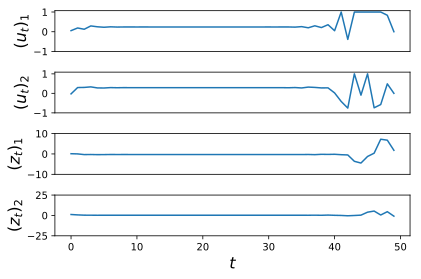

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

f = plt.figure()

# Plot (u_t)_1.
ax = f.add_subplot(411)
plt.plot(a2dr_U[:,0])
plt.ylabel(r"$(u_t)_1$", fontsize=16)
plt.yticks(np.linspace(-1.0, 1.0, 3))
plt.xticks([])

# Plot (u_t)_2.
plt.subplot(4,1,2)
plt.plot(a2dr_U[:,1])
plt.ylabel(r"$(u_t)_2$", fontsize=16)
plt.yticks(np.linspace(-1, 1, 3))
plt.xticks([])

# Plot (z_t)_1.
plt.subplot(4,1,3)
plt.plot(a2dr_Z[:,0])
plt.ylabel(r"$(z_t)_1$", fontsize=16)
plt.yticks([-10, 0, 10])
plt.ylim([-10, 10])
plt.xticks([])

# Plot (z_t)_2.
plt.subplot(4,1,4)
plt.plot(a2dr_Z[:,1])
plt.yticks([-25, 0, 25])
plt.ylim([-25, 25])
plt.ylabel(r"$(z_t)_2$", fontsize=16)
plt.xlabel(r"$t$", fontsize=16)
plt.tight_layout()
plt.show()